    Internet Purchase  Mobile Devices  Hours Math
0                   1            10.0         3.0
1                   1             2.0         4.0
2                   1             2.0         NaN
3                   1             3.0         NaN
4                   1             3.0         NaN
5                   1             3.0         0.0
6                   1             3.0         NaN
7                   1             2.0        12.0
8                   1             5.0        12.0
9                   1             2.0         NaN
10                  1             3.0         7.0
11                  0             2.0         NaN
12                  1             2.0         6.0
13                  1             2.0         NaN
14                  1             NaN         NaN
15                  0             2.0         NaN
16                  1             2.0         0.0
17                  1             2.0         NaN
18                  1             2.0         NaN


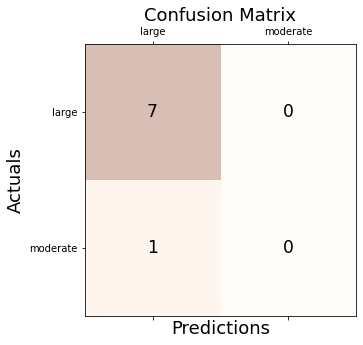

C:\Users\Ruben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


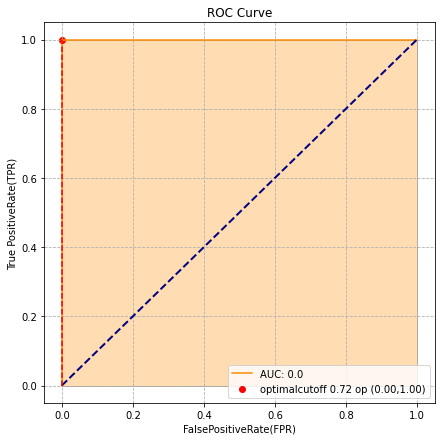

In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from math import nan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.arrays.sparse import dtype


def plot_roc(y_true, y_score, title='ROC Curve', **kwargs):
    from sklearn.metrics import roc_curve, roc_auc_score
    if'pos_label' in kwargs:
        fpr, tpr, thresholds = roc_curve(
            y_true=y_true, y_score=y_score, pos_label=kwargs.get('pos_label'))
        auc = roc_auc_score(y_true, y_score)
    else:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
        auc = roc_auc_score(y_true, y_score)

    # calculate optimal cut-off with Youden index method
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]

    figsize = kwargs.get('figsize', (7, 7))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.grid(linestyle='--')

    # plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', label='AUC: {}'.format(auc))
    ax.set_title(title)
    ax.set_xlabel('FalsePositiveRate(FPR)')
    ax.set_ylabel('True PositiveRate(TPR)')
    ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange', edgecolor='black')

    # plot classifier
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # plot optimal cut-off
    ax.scatter(fpr[optimal_idx], tpr[optimal_idx], label='optimalcutoff {:.2f} op ({:.2f},{:.2f})'.format(
        optimal_threshold, fpr[optimal_idx], tpr[optimal_idx]), color='red')
    ax.plot([fpr[optimal_idx], fpr[optimal_idx]], [
            0, tpr[optimal_idx]], linestyle='--', color='red')
    ax.plot([0, fpr[optimal_idx]], [tpr[optimal_idx],
            tpr[optimal_idx]], linestyle='--', color='red')
    ax.legend(loc='lower right')

    plt.show()


studenq = pd.read_csv('../Questionnaire 20-21.csv', delimiter=';', decimal=',')


def show_confusion_table(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confusion_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(
                x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    ax.set_xticks(range(0, len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(0, len(labels)))
    ax.set_yticklabels(labels)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

## Q.1 We want to predict whether students are very motivated to obtain a degree in Applied Informatics.

# Q.1.A The independent data (the forecasters) are "whether or not to do shopping over the internet", "the number of devices used",
# "the number of hours of mathematics" Put the independent data in a new dataframe with name df
# and make sure the values of the forecasters are numeric and that unrealistic data is changes into nan-values


# df = pd.DataFrame(studenq, columns=["Internet Purchase", "Mobile Devices", "Hours Math"])
df = pd.DataFrame()
df = studenq.loc[:, ["Internet Purchase",
                     "Mobile Devices", "Hours Math"]].copy()

df["Hours Math"] = pd.to_numeric(studenq["Hours Math"], errors='coerce')
df.loc[df["Hours Math"] > 20, "Hours Math"] = np.nan

df.loc[df["Internet Purchase"] == 'No', "Internet Purchase"] = 0
df.loc[df["Internet Purchase"] == 'Yes', "Internet Purchase"] = 1
df["Internet Purchase"] = pd.to_numeric(df["Internet Purchase"])

df.loc[df["Mobile Devices"] == nan, "Mobile Devices"] = 0

print(df)
# print(df.describe())

# Q.1.B In the questionnaire you want to predict the "importance of AI study". This is an ordinal fact that you
# will have to reduce to two possible values: anything equal or more than "Great importance" is "large", everything
# smaller is "moderate". Put this as a column in the dataframe df

studenq['Importance AI Study'] = studenq['Importance AI Study'].astype(pd.CategoricalDtype(
    categories=['Not at all', 'Little importance', 'Moderate importance', 'Great importance', 'Very great importance', 'Extreemly important'], ordered=True))
importance = pd.Series(index=range(len(studenq)), dtype='category').astype(
    pd.CategoricalDtype(categories=["moderate", "large"], ordered=True))
for i in range(0, len(studenq)):
    if studenq.loc[i, 'Importance AI Study'] < 'Great importance':
        importance[i] = 'moderate'
    else:
        importance[i] = 'large'
df['Importance AI Study'] = importance

# Q.1.C Use linear discriminant analysis as model to predict the dependent variable “importance of AI study” my
# means of the independent variables (forecasters). Make the predictions for the available data.

model = LinearDiscriminantAnalysis()
df = df.dropna(axis='rows')
X = df.loc[:, ['Mobile Devices', 'Hours Math', 'Internet Purchase']].copy()
y = df['Importance AI Study'].copy()
model.fit(X, y)
predicted = model.predict(X)

# Q.1.D Look at the results of the evaluation mertrics:
# -Make the confusion matrix
# -Calculate the Accuracy, Precision, Recall and F1-Measure
# -Make a ROC curve


conf_matrix = confusion_matrix(y_true=y, y_pred=predicted)
listoflabels = y.unique().tolist()
show_confusion_table(conf_matrix, listoflabels)

accuracy_score(y_true=y, y_pred=predicted)
precision_recall_fscore_support(y_true=y, y_pred=predicted, beta=1.0)

y_score = model.predict_proba(X)[:, 0]
plot_roc(y, y_score, pos_label='large')
